In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

from collections import OrderedDict


In [5]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

Cloning into 'ants-bees-dataset'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408 (from 1)
Receiving objects: 100% (408/408), 45.03 MiB | 23.87 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])


transform = transforms.Compose([transforms.Resize((224,224)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

training_dataset = datasets.ImageFolder('ants-bees-dataset/train', transform=transform_train)
validation_dataset = datasets.ImageFolder('ants-bees-dataset/val', transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 20, shuffle=False)

# - split data into batches
# - shuffling for dynamically changing fed forwarded data, resulting in diversity
# and ensure closeness to global minima
# (adds complexity by adding diversity ==> reduces overfitting)


**Data Visualization & Analysis**

In [8]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [9]:
classes = ('ant', 'bee')

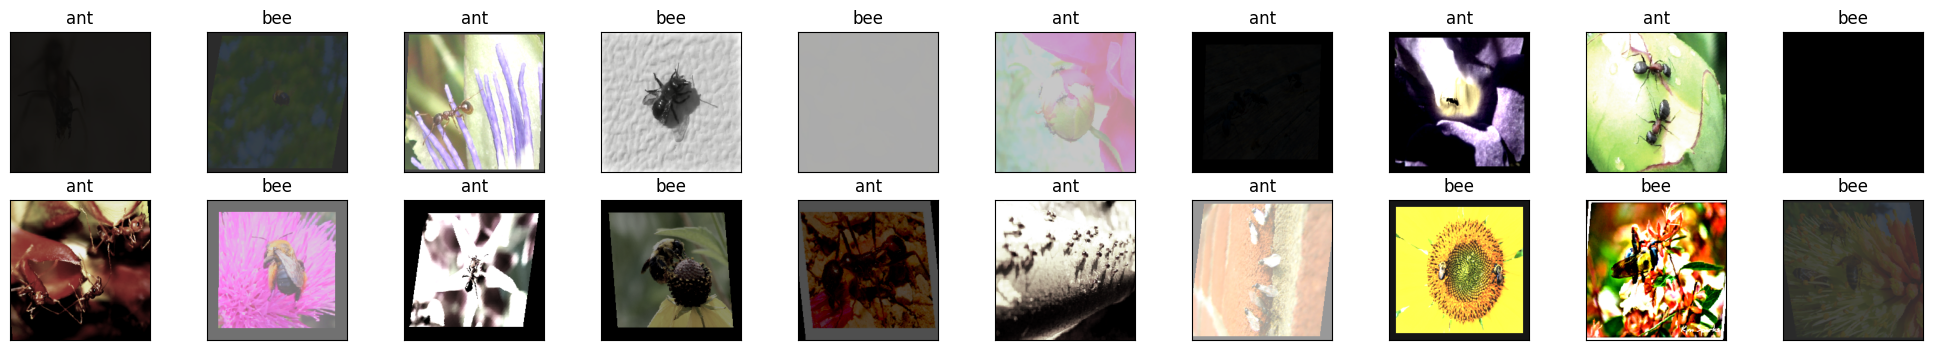

In [10]:
dataiter = iter(training_loader)
images, labels = next(dataiter)
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])



**Neuroplasticity: Transferring Neural Knowledge**

In [36]:
weights = models.VGG16_Weights.DEFAULT
Transfer_CDVNN = models.vgg16(weights=weights)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 72.2MB/s]


In [38]:
for param in Transfer_CDVNN.features.parameters():
  param.requires_grad = False
model = Transfer_CDVNN

In [39]:
import torch.nn as nn

n_inputs = model.classifier[-1].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[-1] = last_layer
model.to(device)
print(model.classifier[-1].out_features)

2


In [40]:
criterion = nn.CrossEntropyLoss() #log_softmax + NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

**Digital Neuroplasticity Process**

In [42]:
epochs = 5
running_loss_history = []
running_accuracy_history = []
val_running_loss_history = []
val_running_accuracy_history = []

for e in range(epochs):
  running_loss = 0.0
  running_accuracy = 0.0
  val_running_loss = 0.0
  val_running_accuracy = 0.0

  for images, labels in training_loader:
    inputs = images.to(device)
    labels = labels.to(device)
    scores = model.forward(inputs)

    loss = criterion(scores, labels)
    _, preds = torch.max(scores, 1)
    running_loss += loss.item()
    running_accuracy += torch.sum(preds == labels.data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step() # Neuroplasticity in action

  else:
    with torch.no_grad():
      for val_images, val_labels in validation_loader:
        val_inputs = val_images.to(device)
        val_labels = val_labels.to(device)
        val_scores = model.forward(val_inputs)

        val_loss = criterion(val_scores, val_labels)
        _, val_preds = torch.max(val_scores, 1)
        val_running_loss += val_loss.item()
        val_running_accuracy += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_accuracy.float()/len(training_loader.dataset)
    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_accuracy.float()/len(validation_loader.dataset)

    running_loss_history.append(epoch_loss)
    running_accuracy_history.append(epoch_acc.cpu())
    val_running_loss_history.append(val_epoch_loss)
    val_running_accuracy_history.append(val_epoch_acc.cpu())

    print(f'Epoch: {e+1} \nTraining/Validation Loss: {epoch_loss:.4f}/{val_epoch_loss:.4}')
    print(f'Training/Validation Accuracy: {epoch_acc:.4f}/{val_epoch_acc:.4f} ')
    print('---------------------------------------------------------------------')



Epoch: 1 
Training/Validation Loss: 0.0083/0.0214
Training/Validation Accuracy: 0.9139/0.9150 
---------------------------------------------------------------------
Epoch: 2 
Training/Validation Loss: 0.0088/0.02093
Training/Validation Accuracy: 0.9344/0.9216 
---------------------------------------------------------------------
Epoch: 3 
Training/Validation Loss: 0.0114/0.02171
Training/Validation Accuracy: 0.8893/0.9346 
---------------------------------------------------------------------
Epoch: 4 
Training/Validation Loss: 0.0098/0.02202
Training/Validation Accuracy: 0.9057/0.9216 
---------------------------------------------------------------------
Epoch: 5 
Training/Validation Loss: 0.0068/0.02117
Training/Validation Accuracy: 0.9467/0.9216 
---------------------------------------------------------------------


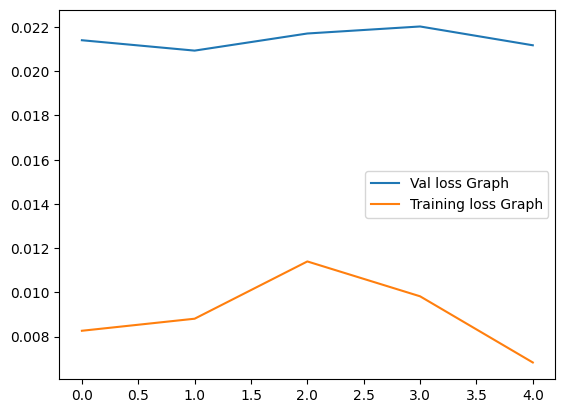

In [43]:
plt.plot(val_running_loss_history, label="Val loss Graph")
plt.plot(running_loss_history, label="Training loss Graph")
plt.legend()

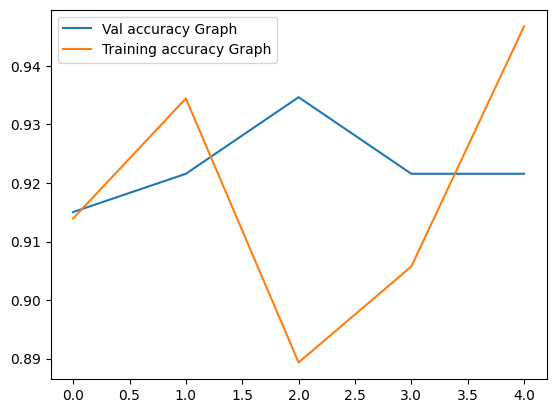

In [44]:
plt.plot(val_running_accuracy_history, label="Val accuracy Graph")
plt.plot(running_accuracy_history, label="Training accuracy Graph")
plt.legend()

**Testing DVNN**

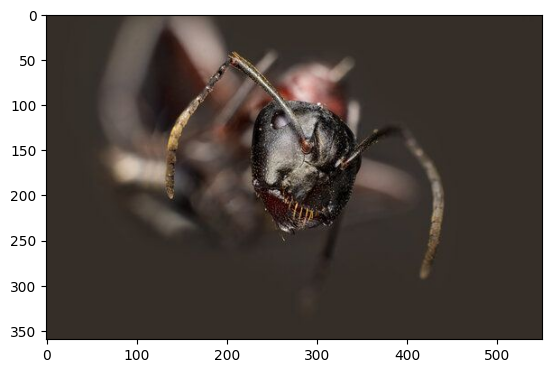

In [45]:
import requests
import PIL.ImageOps
from PIL import Image

url = 'https://imgs.search.brave.com/hkg9ik9t_eYvhjW4ly1e6Tao4vzi_WzpSSJR2is2ap8/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly90NC5m/dGNkbi5uZXQvanBn/LzA0LzQ5Lzk2LzE1/LzM2MF9GXzQ0OTk2/MTU4M180SWZ0YWI5/NnhpRVAwVTZNQ3hn/V3hwc1RlOGo4QWgx/di5qcGc'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

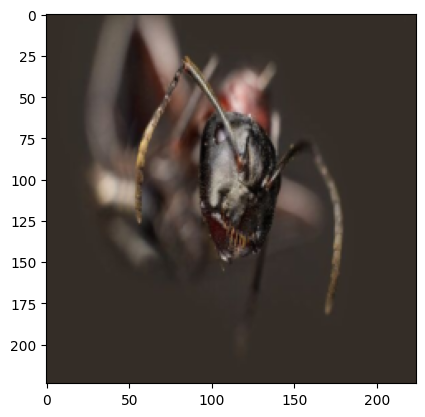

In [46]:
img = transform(img)
plt.imshow(im_convert(img))

In [47]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

ant


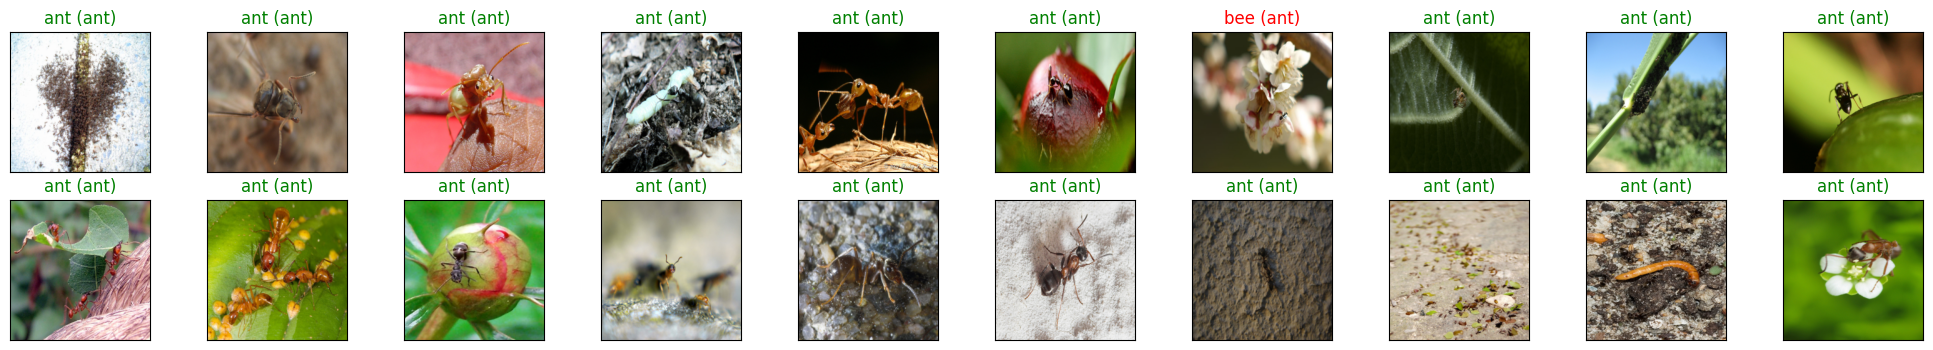

In [48]:
dataiter = iter(validation_loader)
images, labels = next(dataiter)
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))

